# Importação das bibliotecas

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import silhouette_score
import warnings

# Supressão de warnings irrelevantes para manter a execução limpa
warnings.filterwarnings("ignore")

# 📌 Carregar os dados

In [27]:
df = pd.read_csv("crop_yield.csv")

# 📊 Exibir as primeiras linhas, informações gerais e estatísticas descritivas

In [28]:
display(df.head())  # Exibe as primeiras 5 linhas
display(df.info())  # Exibe informações sobre o DataFrame (tipos de dados, valores nulos)
display(df.describe())  # Exibe as estatísticas descritivas (média, desvio padrão, etc.)

,Crop,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
0,"Cocoa, beans",2248.92,17.72,83.40,26.01,11560
1,"Cocoa, beans",1938.42,17.54,82.11,26.11,11253
2,"Cocoa, beans",2301.54,17.81,82.79,26.24,9456
3,"Cocoa, beans",2592.35,17.61,85.07,25.56,9321
4,"Cocoa, beans",2344.72,17.61,84.12,25.76,8800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 6 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Crop                                  156 non-null    object 
 1   Precipitation (mm day-1)              156 non-null    float64
 2   Specific Humidity at 2 Meters (g/kg)  156 non-null    float64
 3   Relative Humidity at 2 Meters (%)     156 non-null    float64
 4   Temperature at 2 Meters (C)           156 non-null    float64
 5   Yield                                 156 non-null    int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 7.4+ KB


None

,Precipitation (mm day-1),Specific Humidity at 2 Meters (g/kg),Relative Humidity at 2 Meters (%),Temperature at 2 Meters (C),Yield
count,156.000000,156.000000,156.000000,156.00000,156.000000
mean,2486.498974,18.203077,84.737692,26.18359,56153.096154
std,289.457914,0.293923,0.996226,0.26105,70421.958897
min,1934.620000,17.540000,82.110000,25.56000,5249.000000
25%,2302.990000,18.030000,84.120000,26.02000,8327.750000
50%,2424.550000,18.270000,84.850000,26.13000,18871.000000
75%,2718.080000,18.400000,85.510000,26.30000,67518.750000
max,3085.790000,18.700000,86.100000,26.81000,203399.000000


# 📌 Conversão da variável categórica "Crop" para valores numéricos usando Label Encoding
# Utilizamos o LabelEncoder para transformar a coluna categórica em valores numéricos.

In [29]:
label_encoder = LabelEncoder()
df["Crop"] = label_encoder.fit_transform(df["Crop"])

# 📌 Tratamento de valores ausentes
# Preenchemos os valores ausentes nas variáveis numéricas com a mediana de cada coluna.
# A mediana é uma boa escolha, pois é robusta a outliers.

In [30]:
df.fillna(df.median(numeric_only=True), inplace=True)

# 📈 Análise exploratória visual (Correlação entre variáveis)
# Criamos um mapa de calor para visualizar as correlações entre as variáveis do dataset,
# ajudando a entender as relações lineares entre as variáveis.

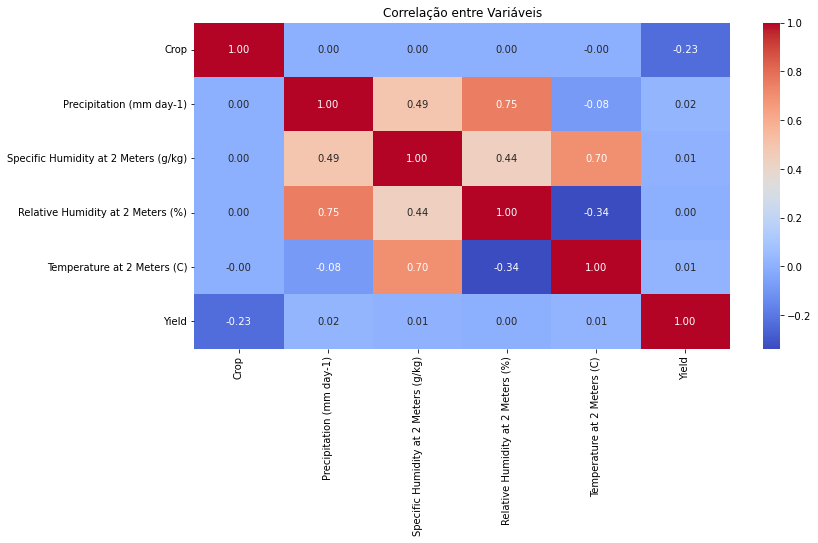

In [31]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlação entre Variáveis")
plt.show()

# 📊 Distribuição das variáveis contínuas
# Utilizamos histogramas para visualizar a distribuição das variáveis contínuas no dataset.
# A distribuição ajuda a entender se os dados são simétricos, têm outliers, etc.

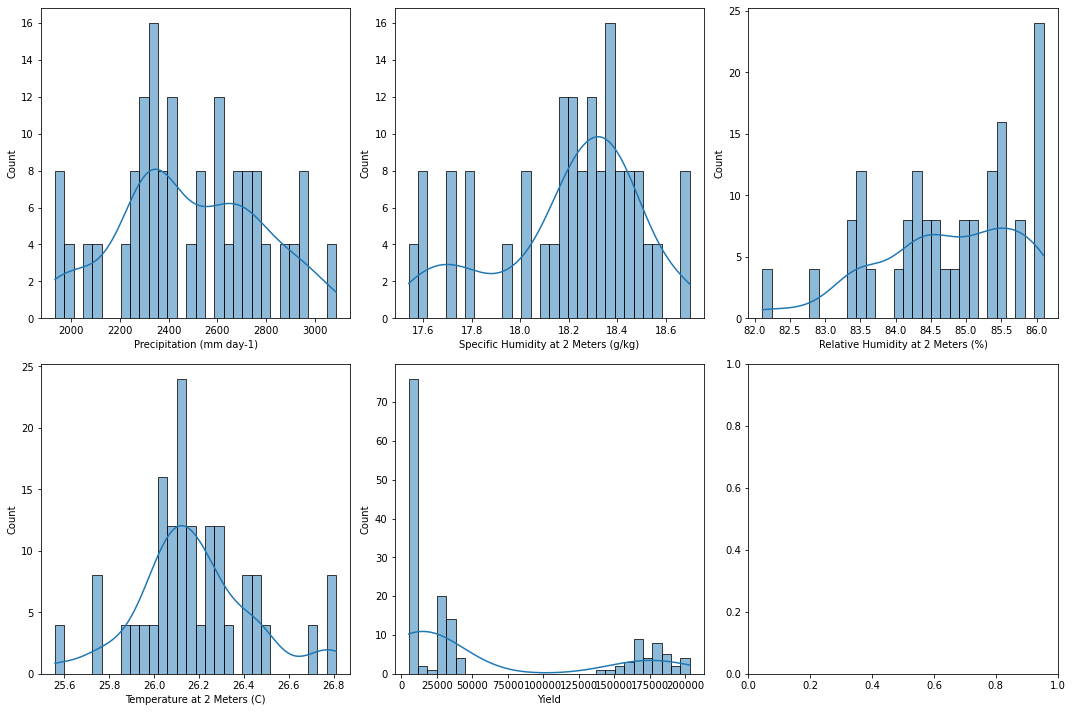

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
cols = ["Precipitation (mm day-1)", "Specific Humidity at 2 Meters (g/kg)", 
        "Relative Humidity at 2 Meters (%)", "Temperature at 2 Meters (C)", "Yield"]
for ax, col in zip(axes.flat, cols):
    sns.histplot(df[col], bins=30, kde=True, ax=ax)  # kde=True para incluir a densidade
plt.tight_layout()
plt.show()

# 📌 Clusterização para identificação de padrões
# Utilizamos KMeans para tentar agrupar as amostras em clusters e identificar padrões no conjunto de dados.
# Primeiro, normalizamos os dados para garantir que todas as variáveis tenham o mesmo peso.

In [33]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df.drop(columns=["Yield"]))  # Exclui 'Yield' da normalização

# Determinação do número ideal de clusters usando o Silhouette Score

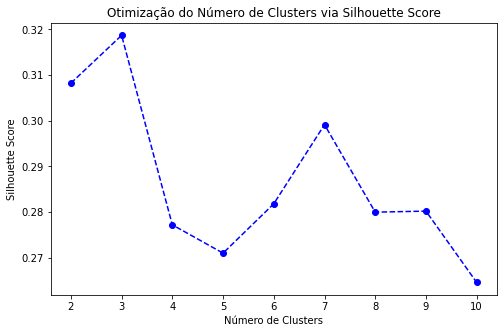

In [35]:
silhouette_scores = []  # Lista para armazenar o Silhouette Score de cada número de clusters
for k in range(2, 11):  # Testamos para k de 2 a 10 clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_scaled)  # Realiza a clusterização
    silhouette_scores.append(silhouette_score(df_scaled, labels))  # Calcula o Silhouette Score para cada k
    
# Visualização do Silhouette Score para cada número de clusters
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o', linestyle='--', color='b')
plt.xlabel("Número de Clusters")
plt.ylabel("Silhouette Score")
plt.title("Otimização do Número de Clusters via Silhouette Score")
plt.show()

# 📌 Aplicação do KMeans com o melhor K (baseado no melhor Silhouette Score)

In [36]:
best_k = np.argmax(silhouette_scores) + 2  # O índice retorna o valor do melhor k, que começa de 2
kmeans = KMeans(n_clusters=best_k, random_state=42)
df["Cluster"] = kmeans.fit_predict(df_scaled)  # Adicionamos a coluna de clusters ao DataFrame

# 📊 Visualização dos clusters
# Criamos um pairplot para visualizar a relação entre as variáveis para cada cluster identificado.

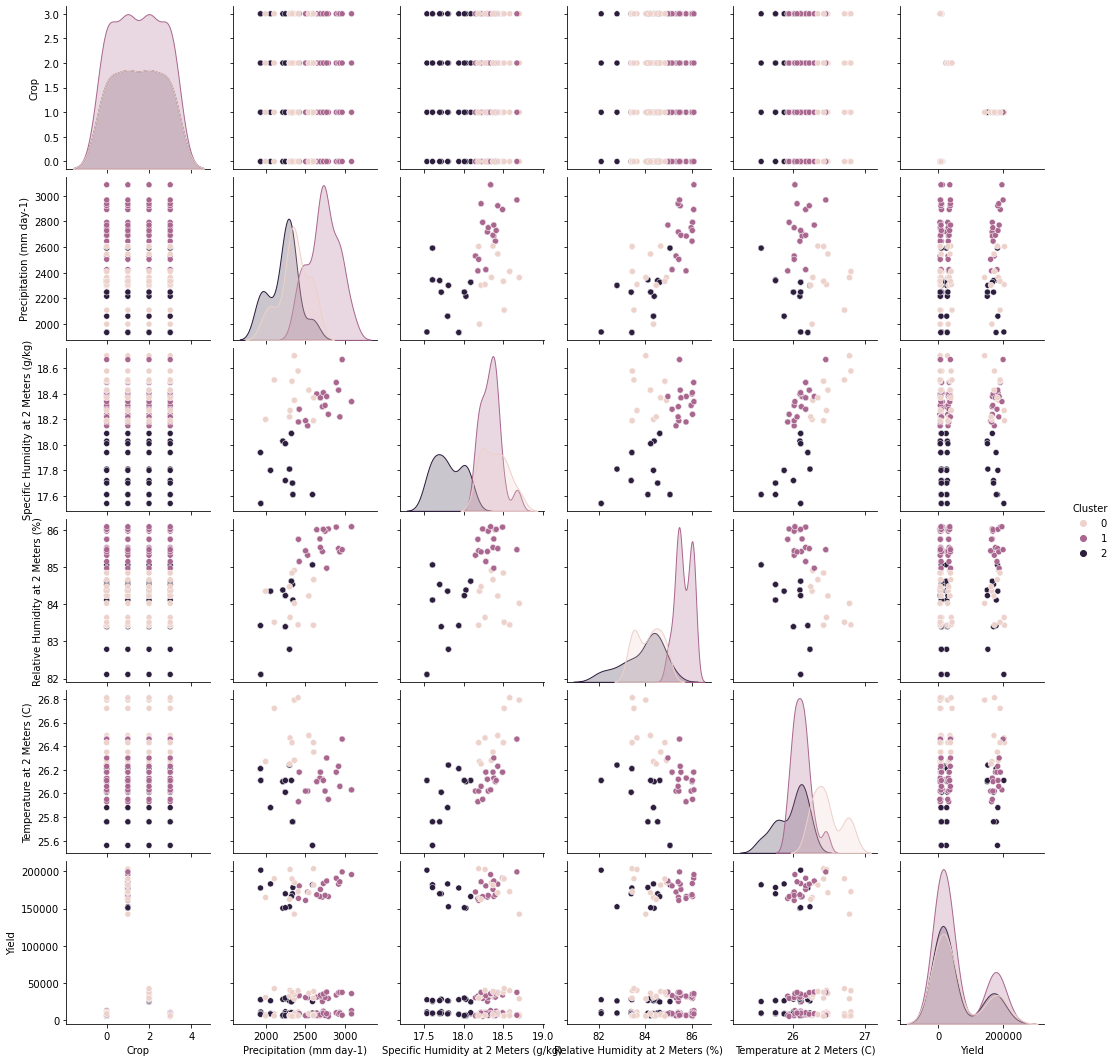

In [37]:
sns.pairplot(df, hue="Cluster", diag_kind="kde")
plt.show()

# 📌 Preparação para modelagem preditiva
# Separação das variáveis explicativas (X) e a variável alvo (y, "Yield")
# Divisão dos dados em treino (80%) e teste (20%)

In [38]:
X = df.drop(columns=["Yield", "Cluster"])  # Excluímos 'Yield' e 'Cluster' para X
y = df["Yield"]  # Definimos 'Yield' como a variável alvo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 📌 Normalização dos dados
# Normalizamos os dados de treino e teste para garantir que todas as variáveis tenham a mesma escala

In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 📌 Modelagem preditiva com otimização via GridSearchCV
# Usamos GridSearchCV para realizar a busca pelos melhores parâmetros para cada modelo de aprendizado de máquina.
# Vamos treinar múltiplos modelos e avaliar o desempenho deles para previsão de "Yield".

In [41]:
models = {
    "Regressão Linear": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "SVM": SVR(),
    "Rede Neural": MLPRegressor(max_iter=500, random_state=42)
}

# Definindo os parâmetros a serem ajustados para cada modelo
tuned_parameters = {
    "Random Forest": {"n_estimators": [100, 200, 300], "max_depth": [10, 20, 30]},
    "Gradient Boosting": {"n_estimators": [100, 200], "learning_rate": [0.01, 0.05, 0.1]},
    "SVM": {"C": [1, 10, 100], "gamma": [0.01, 0.1, 1]},
    "Rede Neural": {"hidden_layer_sizes": [(100,), (100, 50)], "alpha": [0.0001, 0.001]}
}

# Armazenando os resultados dos modelos
results = {}
for name, model in models.items():
    # Se o modelo tem parâmetros para ajuste, utilizamos GridSearchCV
    if name in tuned_parameters:
        grid_search = GridSearchCV(model, tuned_parameters[name], cv=5, scoring='r2')  # 5-fold cross-validation
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_  # Melhor modelo encontrado
    else:
        best_model = model.fit(X_train_scaled, y_train)  # Se não tiver parâmetros, treinamos diretamente
    
    # Predição nos dados de teste
    y_pred = best_model.predict(X_test_scaled)
    
    # Cálculo das métricas de avaliação do modelo
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MAE": mae, "MSE": mse, "R²": r2}
    
    results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by="R²", ascending=False)  # Ordenando pelos melhores R²
print(results_df)

                            MAE           MSE        R²
Gradient Boosting   2829.054946  1.853458e+07  0.995222
Random Forest       2720.047302  2.339486e+07  0.993969
Regressão Linear   53724.485077  4.272527e+09 -0.101459
SVM                38783.499981  5.061272e+09 -0.304797
Rede Neural        43070.356929  5.763783e+09 -0.485905


# 📊 Visualização do desempenho dos modelos
# Criamos um gráfico para comparar os valores de R² entre os modelos.

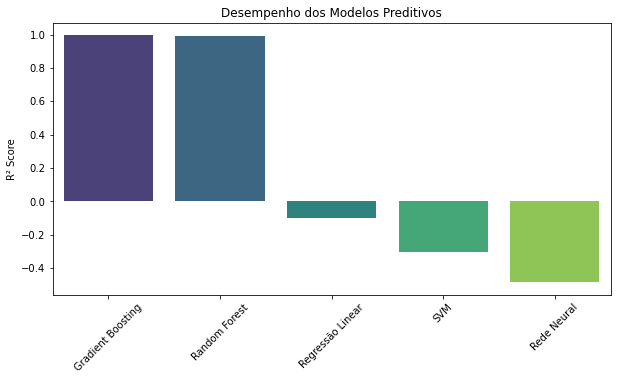

In [42]:
plt.figure(figsize=(10, 5))
sns.barplot(x=results_df.index, y=results_df["R²"], palette="viridis")
plt.xticks(rotation=45)  # Rotacionando os nomes dos modelos para facilitar a leitura
plt.ylabel("R² Score")
plt.title("Desempenho dos Modelos Preditivos")
plt.show()

# Análise de Resultados - Modelos Preditivos para Previsão de Rendimento de Safra

## Introdução

Após realizar a análise preditiva e testar diversos modelos de aprendizado de máquina para prever o rendimento da safra, os seguintes modelos foram avaliados:

- **Gradient Boosting**
- **Random Forest**
- **Regressão Linear**
- **SVM (Support Vector Machine)**
- **Rede Neural (MLP)**

Os resultados obtidos são apresentados a seguir:

## Resultados

| Modelo               | MAE (Mean Absolute Error) | MSE (Mean Squared Error) | R² (Coeficiente de Determinação) |
|----------------------|---------------------------|--------------------------|----------------------------------|
| **Gradient Boosting** | 2829.05                   | 1.85e+07                 | 0.9952                           |
| **Random Forest**     | 2720.05                   | 2.34e+07                 | 0.99397                          |
| **Regressão Linear**  | 53724.49                  | 4.27e+09                 | -0.1015                          |
| **SVM**               | 38783.50                  | 5.06e+09                 | -0.3048                          |
| **Rede Neural**       | 43070.36                  | 5.76e+09                 | -0.4859                          |

### Análise dos Resultados

1. **Gradient Boosting**:
   - **MAE**: 2829.05
   - **MSE**: 1.85e+07
   - **R²**: 0.9952
   - O **Gradient Boosting** obteve o melhor desempenho, com um R² extremamente alto (0.9952), o que indica uma excelente capacidade de previsão. Esse modelo explicou praticamente toda a variabilidade dos dados, sendo altamente preciso.

2. **Random Forest**:
   - **MAE**: 2720.05
   - **MSE**: 2.34e+07
   - **R²**: 0.99397
   - O **Random Forest** obteve um bom desempenho com um R² de 0.99397, o que também reflete uma alta capacidade de generalização. Embora seu desempenho seja ligeiramente inferior ao do Gradient Boosting, ele ainda apresenta uma precisão notável.

3. **Regressão Linear**:
   - **MAE**: 53724.49
   - **MSE**: 4.27e+09
   - **R²**: -0.1015
   - A **Regressão Linear** teve um desempenho muito inferior, com um R² negativo (-0.1015), indicando que o modelo não conseguiu explicar a variabilidade dos dados. Suas previsões foram imprecisas.

4. **SVM**:
   - **MAE**: 38783.50
   - **MSE**: 5.06e+09
   - **R²**: -0.3048
   - O **SVM** também apresentou um R² negativo, o que indica um desempenho ruim para este problema específico. Apesar de ser eficaz em alguns casos, o SVM não conseguiu capturar adequadamente os padrões dos dados.

5. **Rede Neural (MLP)**:
   - **MAE**: 43070.36
   - **MSE**: 5.76e+09
   - **R²**: -0.4859
   - A **Rede Neural** teve um desempenho igualmente insatisfatório com R² negativo, indicando que o modelo não foi bem ajustado aos dados e não conseguiu fazer previsões precisas.

## Análise Geral

- **Gradient Boosting** foi o modelo mais eficaz, com um R² de 0.9952, o que indica uma excelente precisão nas previsões. Esse modelo mostrou ser o mais adequado para este tipo de problema.
- **Random Forest** também apresentou bom desempenho, com um R² de 0.99397, sendo uma excelente alternativa, embora com um desempenho ligeiramente inferior ao do Gradient Boosting.
- **Regressão Linear**, **SVM** e **Rede Neural** apresentaram resultados abaixo do esperado, com R² negativos, indicando que esses modelos não conseguiram capturar adequadamente as relações não lineares dos dados.

## Conclusões

1. **Modelos recomendados**:
   - Para a tarefa de previsão de rendimento da safra, os modelos **Gradient Boosting** e **Random Forest** são altamente recomendados devido ao seu excelente desempenho.
   - O **Gradient Boosting** se destaca como o modelo mais preciso e robusto.
   
   
2. **Modelos a serem ajustados**:
   - **SVM** e **Rede Neural** podem ser explorados com ajustes mais profundos em seus parâmetros. No entanto, com base nos resultados atuais, esses modelos não são os mais adequados para este conjunto de dados específico.
   
   
3. **Próximos passos**:
   - **Gradient Boosting** e **Random Forest** podem ser utilizados para otimizar ainda mais as previsões, talvez com um fine-tuning dos parâmetros para melhorar ainda mais a performance.
   - A **Regressão Linear**, **SVM**, e **Rede Neural** podem ser descartadas ou reavaliadas com ajustes mais específicos, como o aumento da complexidade do modelo e melhor pré-processamento dos dados.
   
 ## Limitações do Trabalho

Embora os modelos analisados tenham apresentado resultados promissores, existem algumas limitações que devem ser consideradas:

1. **Modelos Não Lineares**:
   - Embora os modelos **Random Forest** e **Gradient Boosting** sejam eficazes para dados não lineares, a falta de uma exploração mais profunda de relações não lineares mais complexas pode limitar seu desempenho em cenários futuros. O uso de modelos de redes neurais mais profundos ou até mesmo modelos híbridos pode ser considerado para melhor capturar esses padrões.


2. **Fatores Externos**:
   - Modelos preditivos não consideram fatores externos que podem impactar o rendimento da safra, como mudanças climáticas repentinas ou eventos extremos. Esses fatores não estavam presentes no conjunto de dados analisado e podem ser incorporados para melhorar a robustez das previsões.

### Conclusão

As limitações mencionadas representam oportunidades de melhoria para o futuro, especialmente no que diz respeito à coleta de dados mais detalhados e ao ajuste de parâmetros. A utilização de novas abordagens de modelagem e exploração de variáveis adicionais pode resultar em modelos mais precisos e robustos, capazes de lidar melhor com as complexidades dos dados relacionados ao rendimento da safra.
Com esses resultados, é possível seguir com a implementação de um modelo robusto para previsão do rendimento das safras, utilizando **Gradient Boosting** como o principal modelo de produção.
